In [1]:
import time
import zipfile
import imblearn
import numpy as np
import pandas as pd
from os import path
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_validate, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, PrecisionRecallDisplay 

from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
class Data():
    def __init__(self, oversample = False):
        self.features = [
            # Chest accelerometer sensor
            'chest_accel_x', 'chest_accel_y', 'chest_accel_z',
    
            # ECG (2 leads)
            'ecg_1', 'ecg_2',

            # Left ankle sensors
            'left_accel_x', 'left_accel_y', 'left_accel_z',
            'left_gyro_x', 'left_gyro_y', 'left_gyro_z',
            'left_mag_x', 'left_mag_y', 'left_mag_z',

            # Right lower arm sensors
            'right_accel_x', 'right_accel_y', 'right_accel_z',
            'right_gyro_x', 'right_gyro_y', 'right_gyro_z',
            'right_mag_x', 'right_mag_y', 'right_mag_z',
        ]
        self.load_data()
        self.update_labels()
        if (oversample):
            self.oversample()
        
    def load_data(self, file_name = 'mhealth.csv'):
        if not path.exists(file_name):
            df = load_zipped_csv_dir('MHEALTHDATASET.zip', prefix = 'mHealth_subject', include_file_column = True, header = None, names = self.columns)
            df.to_csv('mhealth.csv', index = False)
    
    def view_data(self, n = 5):
        print(self.df.head(n))
        
    def update_labels(self):
        df = pd.read_csv('mhealth.csv')
        df = df.drop(['file'], axis = 1)
        df = df[df['activity'] != 0]
        df['label'] = np.where(df['activity'].isin([1, 2, 3]), 0, 1)
        df = shuffle(df)
        df.to_csv('mhealth_s_m.csv', index = False)
        self.df = df
        self.X = df[self.features]
        self.y = df['label']
        
    def oversample(self):
        oversample = RandomOverSampler(sampling_strategy = 'minority')
        X_over, y_over = oversample.fit_resample(self.X, self.y)
#         print(Counter(self.y), Counter(y_over))
        self.X = X_over
        self.y = y_over
        
    def get_data(self):
        train_X, test_X, train_y, test_y = train_test_split(self.X, self.y, test_size = 0.2, random_state = 69)
        return train_X, test_X, train_y, test_y

In [3]:
data = Data(oversample = True)
train_X, test_X, train_y, test_y = data.get_data()

data_ub = Data(oversample = False)
train_X_ub, test_X_ub, train_y_ub, test_y_ub = data_ub.get_data()

In [4]:
def pick_max_iter(X, y):
    start_time = time.time()
    for max_iter in [100, 500, 1000]:
        model = LogisticRegression(max_iter = max_iter)
        print(model)
        scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']
        scores = cross_validate(model, X, y, scoring = scoring, cv = KFold(n_splits = 5), return_train_score = True)
        print('max_iter', max_iter)
        print('train accuracy', np.mean(scores['train_accuracy']), '\n',
              'test accuracy', np.mean(scores['test_accuracy']), '\n',
              'train f1', np.mean(scores['train_f1']), '\n',
              'test f1', np.mean(scores['test_f1']), '\n',
              'train recall', np.mean(scores['train_recall']), '\n',
              'test recall', np.mean(scores['test_recall']), '\n',
              'train precision', np.mean(scores['train_precision']), '\n',
              'test precision', np.mean(scores['test_precision']), '\n',
              'train roc auc', np.mean(scores['train_roc_auc']), '\n',
              'test roc auc',np.mean(scores['test_roc_auc']), '\n'
             )
    print('Took', time.time() - start_time, 's to run')
pick_max_iter(train_X, train_y)

LogisticRegression()
max_iter 100
train accuracy 0.8261771307506331 
 test accuracy 0.8260202613933023 
 train f1 0.8220256067728343 
 test f1 0.8218408592824729 
 train recall 0.8020784354565507 
 test recall 0.8018933584460669 
 train precision 0.8430860159250939 
 test precision 0.8429069641561805 
 train roc auc 0.8966963371551625 
 test roc auc 0.8966041393385602 

LogisticRegression(max_iter=500)
max_iter 500
train accuracy 0.833391011532157 
 test accuracy 0.8332603018048725 
 train f1 0.8299999906266343 
 test f1 0.8298620222991093 
 train recall 0.8128484862204746 
 test recall 0.8127045387107621 
 train precision 0.8478926716520465 
 test precision 0.8477637841139668 
 train roc auc 0.9122794795459355 
 test roc auc 0.9122359879137036 

LogisticRegression(max_iter=1000)
max_iter 1000
train accuracy 0.832916724594587 
 test accuracy 0.8328495041255428 
 train f1 0.8295807838824556 
 test f1 0.8294961103746148 
 train recall 0.8127477376937511 
 test recall 0.8126048859230464 


In [8]:
class Pick_Learner():
    def __init__(self, X, y, n_splits = 5):
        self.models = [
            LogisticRegression(), RidgeClassifier(), SGDClassifier(), 
            DecisionTreeClassifier(),
            MLPClassifier(),
            GaussianNB(),
            BaggingClassifier(), RandomForestClassifier(), ExtraTreesClassifier(), 
            AdaBoostClassifier(), GradientBoostingClassifier(),
            LinearSVC(),
            #KNeighborsClassifier(),
        ]
        self.X = X
        self.y = y
        self.scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']
        self.kf = KFold(n_splits = n_splits)
        self.skf = StratifiedKFold(n_splits = n_splits)
    
    def print_score(self, model, scores):
        print(model)
        print('-------------------------------------')
        print('train accuracy', np.mean(scores['train_accuracy']),'\n',
              'train f1', np.mean(scores['train_f1']),'\n',
              'train precision', np.mean(scores['train_precision']),'\n',
              'train recall', np.mean(scores['train_recall']),'\n',
              'train roc auc', np.mean(scores['train_roc_auc']))
        print()      
        print('test accuracy', np.mean(scores['test_accuracy']),'\n',
              'test f1', np.mean(scores['test_f1']),'\n',
              'test precision', np.mean(scores['test_precision']),'\n',
              'test recall', np.mean(scores['test_recall']),'\n',
              'test roc auc', np.mean(scores['test_roc_auc'])
             )
        
    def K_fold_balanced(self):
        X = self.X
        y = self.y
        print('Balanced Data')
        for model in self.models:
            start_time = time.time()
            scores = cross_validate(model, X, y, scoring = self.scoring, cv = self.kf, return_train_score = True)
            self.print_score(model, scores)
            print('Took', time.time() - start_time, 's to run')
            print('=======================================')
            
    def K_fold_unbalanced(self):
        X = self.X
        y = self.y
        scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']
        print('Unbalanced Data')
        for model in self.models:
            start_time = time.time()
            scores = cross_validate(model, X, y, scoring = self.scoring, cv = self.skf, return_train_score = True)
            self.print_score(model, scores)
            print('Took', time.time() - start_time, 's to run')
            print('=======================================')
    
    def K_fold_ComplementNB(self):
        scaler = MinMaxScaler()
        train_X_ub = scaler.fit_transform(self.X)
        scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']
        print('Unbalanced Data with Complement Naive Bayes')
        model = ComplementNB()
        start_time = time.time()
        scores = cross_validate(model, train_X_ub, self.y, scoring = self.scoring, cv = self.skf, return_train_score = True)
        self.print_score(model, scores)
        print('Took', time.time() - start_time, 's to run')
        print('=======================================')
        

In [9]:
print('5 K cross validation for 80% balanced and unbalanced data')
Pick_Learner(train_X, train_y).K_fold_balanced()
Pick_Learner(train_X_ub, train_y_ub).K_fold_unbalanced()

print('5 K cross validation for 80% unbalanced data using Complement Naive Bayes')
Pick_Learner(train_X_ub, train_y_ub).K_fold_ComplementNB()

5 K cross validation for 80% balanced and unbalanced data
Balanced Data
LogisticRegression()
-------------------------------------
train accuracy 0.8261771307506331 
 train f1 0.8220256067728343 
 train precision 0.8430860159250939 
 train recall 0.8020784354565507 
 train roc auc 0.8966963371551625

test accuracy 0.8260202613933023 
 test f1 0.8218408592824729 
 test precision 0.8429069641561805 
 test recall 0.8018933584460669 
 test roc auc 0.8966041393385602
Took 9.149017572402954 s to run
RidgeClassifier()
-------------------------------------
train accuracy 0.8276485350002541 
 train f1 0.8214685593945779 
 train precision 0.8526876509994518 
 train recall 0.7924549542698122 
 train roc auc 0.9028179527224847

test accuracy 0.8277356755375983 
 test f1 0.8215629861972463 
 test precision 0.8527522419962038 
 test recall 0.7925797536442365 
 test roc auc 0.9027859489558079
Took 2.599125862121582 s to run
SGDClassifier()
-------------------------------------
train accuracy 0.840987

BaggingClassifier()
-------------------------------------
train accuracy 0.9999453663659412 
 train f1 0.9999626546796426 
 train precision 0.9999763479304502 
 train recall 0.999948962095171 
 train roc auc 0.9999999786197151

test accuracy 0.9991112927587974 
 test f1 0.9993925226456074 
 test precision 0.9993975117631173 
 test recall 0.9993875451729803 
 test roc auc 0.9998899460524976
Took 127.24886059761047 s to run
RandomForestClassifier()
-------------------------------------
train accuracy 1.0 
 train f1 1.0 
 train precision 1.0 
 train recall 1.0 
 train roc auc 1.0

test accuracy 0.9998798059014249 
 test f1 0.9999178440279856 
 test precision 0.9998954448564386 
 test recall 0.999940248466784 
 test roc auc 0.999999920135693
Took 245.80318307876587 s to run
ExtraTreesClassifier()
-------------------------------------
train accuracy 1.0 
 train f1 1.0 
 train precision 1.0 
 train recall 1.0 
 train roc auc 1.0

test accuracy 1.0 
 test f1 1.0 
 test precision 1.0 
 test re

In [10]:
class Trainer():
    def __init__(self, train_X, train_y, test_X, test_y, model = LogisticRegression(), data_type = 'Balanced'):
        self.data_type = data_type
        self.train_X = train_X
        self.train_y = train_y
        self.test_X = test_X
        self.test_y = test_y
        self.model = model
        
    def predict(self):
        model = self.model
        print('Model:', model)
        model.fit(self.train_X, self.train_y)
        y_pred = model.predict(self.test_X)
        print('Scores for', self.data_type, ':')
        print('Accuracy:', accuracy_score(self.test_y, y_pred))
        print('F1 Score:', f1_score(self.test_y, y_pred))
        print('Precision Score:', precision_score(self.test_y, y_pred))
        print('Recall Score:', recall_score(self.test_y, y_pred))
        print('ROC Area Under Curve:', roc_auc_score(self.test_y, y_pred))
        print('Confusion Matrix:')
        print(confusion_matrix(self.test_y, y_pred))
        print('Classification Report:')
        print(classification_report(self.test_y, y_pred))
        display = PrecisionRecallDisplay.from_estimator(
            model, self.test_X, self.test_y, name = model
        )
        display.ax_.set_title('2-class Precision-Recall curve ' + self.data_type)
        
    def dummy_comparision(self):
        model = DummyClassifier(strategy = "most_frequent")
        print('Model:', model)
        model.fit(train_X, self.train_y)
        y_pred = model.predict(self.test_X)
        print('Scores for Dummy Classifier:')
        print('Accuracy:', accuracy_score(self.test_y, y_pred))
        print('F1 Score:', f1_score(self.test_y, y_pred))
        print('Precision Score:', precision_score(self.test_y, y_pred))
        print('Recall Score:', recall_score(self.test_y, y_pred))
        print('ROC Area Under Curve:', roc_auc_score(self.test_y, y_pred))
        print('Confusion Matrix:')
        print(confusion_matrix(self.test_y, y_pred))

Running the best model on the entire dataset. Training: 80%, Testing: 20% for both balanced and unbalanced data
Balanced
Model: DecisionTreeClassifier()
Scores for Balanced :
Accuracy: 0.9993626386758818
F1 Score: 0.9993605115907274
Precision Score: 0.9997600959616153
Recall Score: 0.9989612465041949
ROC Area Under Curve: 0.9993614668792173
Confusion Matrix:
[[50342    12]
 [   52 50008]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50354
           1       1.00      1.00      1.00     50060

    accuracy                           1.00    100414
   macro avg       1.00      1.00      1.00    100414
weighted avg       1.00      1.00      1.00    100414


Unbalanced
Model: DecisionTreeClassifier()
Scores for Unbalanced :
Accuracy: 0.9983974125497166
F1 Score: 0.9989043824701196
Precision Score: 0.9989839827874731
Recall Score: 0.9988247948370648
ROC Area Under Curve: 0.9980291590133249
Confusion Matrix:
[[18

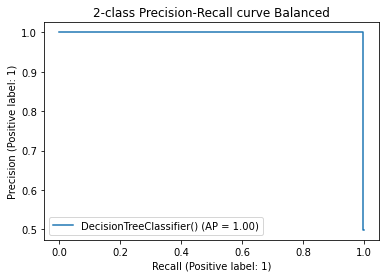

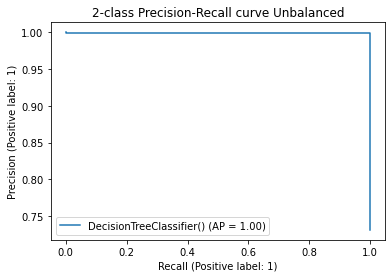

In [19]:
print('Running the best model on the entire dataset. Training: 80%, Testing: 20% for both balanced and unbalanced data')
model = DecisionTreeClassifier() #specify model to be used here

print('Balanced')
Trainer(train_X, train_y, test_X, test_y, model = model, data_type = 'Balanced').predict()
print()
print('Unbalanced')
Trainer(train_X_ub, train_y_ub, test_X_ub, test_y_ub, model = model, data_type = 'Unbalanced').predict()
print()
print('Balanced Dummy Classifer')
Trainer(train_X, train_y, test_X, test_y).dummy_comparision()

In [16]:
class Sharhad_Net():
    def __init__(self, train_X, train_y, test_X, test_y, data_type = 'Balanced', 
                 batch_size = 32, learning_rate = 1e-3, epoch = 50, verbose = 0):
        self.data_type = data_type
        self.train_X = train_X
        self.train_y = train_y
        self.test_X = test_X
        self.test_y = test_y
        print(data_type)
        
        #Model
        normalizer = preprocessing.Normalization()
        normalizer.adapt(np.array(train_X))
        model = tf.keras.Sequential([
              normalizer,
              layers.Dense(128, activation = 'elu', kernel_regularizer = regularizers.l2(0.01)),
              layers.Dropout(0.5),
              layers.Dense(128, activation = 'elu', kernel_regularizer = regularizers.l2(0.01)),
              layers.Dropout(0.5),
              layers.Dense(2),
              layers.Softmax()])
        start = time.time()
        
        model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics = ['accuracy'])

        fitted_model = model.fit(train_X, train_y, epochs = epoch, verbose = verbose, batch_size = batch_size)

        test_loss, test_acc = model.evaluate(test_X, test_y, verbose = 2)
        print('Test accuracy:', test_acc)
        self.plot_loss(fitted_model)
        
        dnn_predictions = model.predict(test_X)
        self.calc_accuracy(dnn_predictions)
        
        print('AUC: {}'.format(roc_auc_score(test_y, dnn_predictions[:, 1])))
        print('Time taken:', time.time() - start, 's')
        print('\n\n')

    def plot_loss(self, history):
        plt.plot(history.history['loss'], label = 'loss')
        plt.plot(history.history['accuracy'], label = 'accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.title('Loss and Accuracy Plot for ' + self.data_type)
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def calc_accuracy(self, prediction, tp = 0, tn = 0, fp = 0, fn = 0):
        test_y_arr = self.test_y.to_numpy()
        for x in range(len(prediction)):
            if test_y_arr[x] == 1:
                if np.argmax(prediction[x]) == 1:
                    tp = tp + 1
                else:
                    fn = fn + 1
            else:
                if np.argmax(prediction[x]) == 0:
                    tn = tn + 1
                else:
                    fp = fp + 1

        accuracy = (tp + tn)/(tp + fp + fn + tn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        specificity = tn / (tn + fp)

        print('Accuracy:', accuracy)
        print('Precision:', precision)
        print('Recall:', recall)
        print('Specificity:', specificity)
        print('F Score:', 2 * (recall * precision) / (recall + precision))  

Running Sharhad_Net on the entire dataset. Training: 80%, Testing: 20% for both balanced and unbalanced data
Balanced
3138/3138 - 1s - loss: 0.2936 - accuracy: 0.9463 - 1s/epoch - 447us/step
Test accuracy: 0.9463222026824951


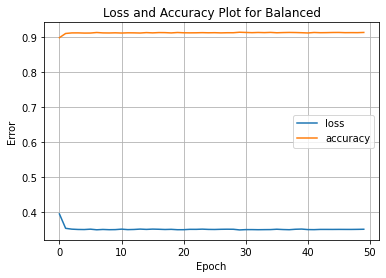

Accuracy: 0.9463222259844245
Precision: 0.9967970105431736
Recall: 0.8952057530962845
Specificity: 0.9971402470508798
F Score: 0.9432739059967585
AUC: 0.9780528020623176
Time taken: 583.9609344005585 s



Unbalanced
2145/2145 - 1s - loss: 0.2998 - accuracy: 0.9116 - 1s/epoch - 538us/step
Test accuracy: 0.9116391539573669


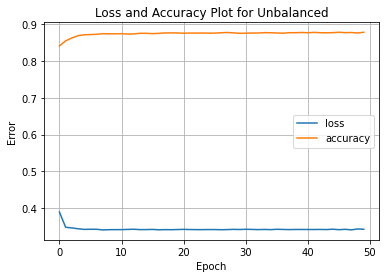

Accuracy: 0.9116391555821035
Precision: 0.9233956834532374
Recall: 0.958728388176241
Specificity: 0.7834011391375102
F Score: 0.9407303892347233
AUC: 0.9695016510559348
Time taken: 400.5000913143158 s





In [17]:
print('Running Sharhad_Net on the entire dataset. Training: 80%, Testing: 20% for both balanced and unbalanced data')
Sharhad_Net(train_X, train_y, test_X, test_y)
Sharhad_Net(train_X_ub, train_y_ub, test_X_ub, test_y_ub, data_type = 'Unbalanced')

Things to do:
1. run all top models on the 20% test set, report all scores done
2. run on two_layer_nn
3. run against dummy classifier
4. pdf report
5. Answer all questions in email/readme.md
6. why i am leaving out class 0, what i did to pick s vs m